In [1]:
from devito import *
from examples.seismic.source import WaveletSource, RickerSource, GaborSource, TimeAxis
from examples.seismic import *
import numpy as np
from scipy import signal
from sympy import init_printing, latex
init_printing(use_latex=True)

In [2]:
%matplotlib inline

## Example: Viscoelastic Finite-difference modeling 

The example considered here is based on Numerical example 1 (page 1448) introduced in

[1] Robertsson, J.O., Blanch, J.O. and Symes, W.W., 1994. Viscoelastic finite-difference modeling. Geophysics, 59(9), pp.1444-1456. 
https://library.seg.org/doi/abs/10.1190/1.1443701

A more detailed explanation of the Visco-Elastic Finite-Difference scheme used in [1] is provided by [2] (page 15) in more detail:

[2] Thorbecke, J., 2012. 2d finite-difference wavefield modelling. Alındığı tarih, 1, p.2012.
https://janth.home.xs4all.nl/Software/fdelmodcManual.pdf

This notebook aims to model anelastic behavior exhibited in real earth media by using Devito to generate the Viscoelastic staggered Finite-Difference scheme given by Robertsson et al.[1] and 'reproduce' the simulations in figure 5 for the 2D case in Numerical Example 1.

The domain under consideration, as specified by the paper, has a spatial extent of $700m \times 350m$ with a grid spacing $h$ of $1m$. Let $x$ represent the horizontal coordinate and $z$ the depth. 





In [3]:
# Initial grid: 700m x 350m, with spacing 1m

# Define a physical size
Lx = 700.
Lz = 350
h = 1              # 1 metre spacing
Nx = int(Lx/h)+1
Nz = int(Lz/h)+1

spacing = (h, h)  # Grid spacing in m. 

extent = (Lx, Lz) # Dimensions of domain
shape = (Nx, Nz) # Number of grid point (nx, nz)

x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent[1]/(shape[1]-1)))
grid = Grid(extent=extent, shape=shape, dimensions=(x, z))

## Modelling the velocity profile of the incised valley

The following code block is used to build the required topology of an incised valley as specified by Figure 4 [1]. A gaussian is used to model the topology of each layer in the incised valley model.

<class 'devito.data.data.Data'>


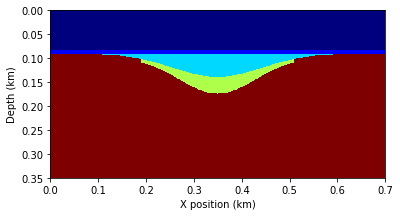

In [54]:
##Testing new Viscoelastic model class from model.py

#Test case just to make sure topology is correct

origin = (0., 0.)

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

# Define a velocity profile. The velocity is in km/s
V_p = np.empty(shape, dtype=np.float32)
V_p[:, :70] = 1.52 #water
V_p[:, 70:80] = 1.60 #layer 1
V_p[:, 80:90] = 1.75 #layer 2
V_p[:, 80:] = 2.2 #layer 4
#Incised Layers
for i in range(V_p.shape[0]):
    j1 = int(gaussian(i, 350, 85) * 85)
    j2 = int(gaussian(i, 350, 100) * 55)
    if j1 > 10: V_p[i, 90 : 90 + j1] = 1.9 #layer 3
    V_p[i, 80 : 80 + j2] = 1.75 #layer 2
    
Q_p = np.empty(shape, dtype=np.float32)
Q_p[:, :70] = 10000 #water
Q_p[:, 70:80] = 40 #layer 1
Q_p[:, 80:90] = 50 #layer 2
Q_p[:, 80:] = 100 #layer 4
#Incised Layers
for i in range(Q_p.shape[0]):
    j1 = int(gaussian(i, 350, 85) * 85)
    j2 = int(gaussian(i, 350, 100) * 55)
    if j1 > 10: Q_p[i, 90 : 90 + j1] = 50 #layer 3
    Q_p[i, 80 : 80 + j2] = 50 #layer 2

V_s = np.empty(shape, dtype=np.float32)
V_s[:, :70] = 0 #water
V_s[:, 70:80] = 0.4 #layer 1
V_s[:, 80:90] = 0.8 #layer 2
V_s[:, 80:] = 1.2 #layer 4
#Incised Layers
for i in range(V_s.shape[0]):
    j1 = int(gaussian(i, 350, 85) * 85)
    j2 = int(gaussian(i, 350, 100) * 55)
    if j1 > 10: V_s[i, 90 : 90 + j1] = 1.0 #layer 3
    V_s[i, 80 : 80 + j2] = 0.8 #layer 2

Q_s = np.empty(shape, dtype=np.float32)
Q_s[:, :70] = 0 #water
Q_s[:, 70:80] = 30 #layer 1
Q_s[:, 80:90] = 35 #layer 2
Q_s[:, 80:] = 70 #layer 4
#Incised Layers
for i in range(Q_s.shape[0]):
    j1 = int(gaussian(i, 350, 85) * 85)
    j2 = int(gaussian(i, 350, 100) * 55)
    if j1 > 10: Q_s[i, 90 : 90 + j1] = 45 #layer 3
    Q_s[i, 80 : 80 + j2] = 35 #layer 2

density = np.empty(shape, dtype=np.float32)
density[:, :70] = 1.05 #water
density[:, 70:80] = 1.3 #layer 1
density[:, 80:90] = 1.5 #layer 2
density[:, 80:] = 2.0 #layer 4

#Incised Layers
for i in range(density.shape[0]):
    j1 = int(gaussian(i, 350, 85) * 85)
    j2 = int(gaussian(i, 350, 100) * 55)
    if j1 > 10: density[i, 90 : 90 + j1] = 1.5 #layer 3
    density[i, 80 : 80 + j2] = 1.5 #layer 2

nbpml = 20

model_visco = ModelViscoElastic(vp = V_p, vs = V_s, qp = Q_p, qs = Q_s, rho = density, origin=origin, shape=shape, spacing=spacing,
              space_order=4, nbpml = nbpml, dtype = np.float32)

domain_size = 1.e-3 * np.array(model_visco.domain_size)
extent = [model_visco.origin[0], model_visco.origin[0] + domain_size[0], model_visco.origin[1] + domain_size[1], model_visco.origin[1]]
plt.imshow(np.transpose(model_visco.vp.data_with_halo), animated=True, cmap=cm.jet,
            vmin=np.min(model_visco.vp.data_with_halo), vmax=np.max(model_visco.vp.data_with_halo), extent=extent)
#Uncomment to plot without absorbing boundaries
#plt.show()
#plt.imshow(np.transpose(model_visco.vp.data), animated=True, cmap=cm.jet,
            #vmin=np.min(model_visco.vp.data), vmax=np.max(model_visco.vp.data), extent=extent)
plt.xlabel('X position (km)')
plt.ylabel('Depth (km)')

# print(type(V_p), V_p)
# plot_velocity(model_visco)

print(type(model_visco.vp.data_with_halo))

## Ricker Wavelet as Explosive Source


Ths seismic experiment is modeled using a Ricker Wavelet with a peak-frequency of $80$Hz as the source term which is located at $(200m,40m)$ given in Figure 4[1]. The source signature $g(t)$ is defined as the derivative of a Gaussian pulse:

$$g(t) = -2 \alpha(t - t_0)e^{-\alpha(t-t_0)^2}$$

The same timestep as Numerical Example 1 is used, $dt = 0.15ms$ which leads to the maximum Courant number of 0.33, in order to reproduce the same results.

In [55]:
class DGaussSource(WaveletSource):
    
    def wavelet(self, f0, t):
        """
        Defines a wavelet with a peak frequency f0 at time t.

        Parameters
        ----------
        f0 : float
            Peak frequency in kHz.
        t : TimeAxis
            Discretized values of time in ms.
        """
        a = 0.004
        return -2.*a*(t - 1/f0) * np.exp(-a * (t - 1/f0)**2)

t0, tn = 0., 300 #300ms is tested first inorder to reproduce Figure 5a i.e a 50ms snapshot
dt = 0.15         #0.15ms for timestep 

time_range = TimeAxis(start=t0, stop=tn, step=dt)
nt = time_range.num  # number of time steps

f0 = 0.08 # Source peak frequency of 80hz

#Initialize ricketwavelet as source
src = RickerSource(name='src', grid=grid, f0=f0, npoint=1, 
                   time_range=time_range)

#Location of source
src.coordinates.data[:] = [200., 40.]


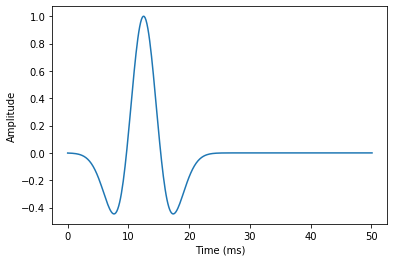

In [56]:
#NBVAL_SKIP
src.show()

Robertsson et al.[1] conclude that a staggered scheme of second-order accuracy in time and fourth order accuracy in space is optimally efficient. The same scheme will be used in order to reproduce their results.

In [57]:
so = 4 #define the space order
to = 2 #define the time order

In [58]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

V_p = Function(name='V_p', grid=grid, space_order=so)
V_p.data[:, :70] = 1.52 #water
V_p.data[:, 70:80] = 1.60 #layer 1
V_p.data[:, 80:90] = 1.75 #layer 2
V_p.data[:, 80:] = 2.2 #layer 4
#Incised Layers
for i in range(V_p.shape[0]):
    j1 = int(gaussian(i, 350, 85) * 85)
    j2 = int(gaussian(i, 350, 100) * 55)
    if j1 > 10: V_p.data[i, 90 : 90 + j1] = 1.9 #layer 3
    V_p.data[i, 80 : 80 + j2] = 1.75 #layer 2

Q_p = Function(name='Q_p', grid=grid, space_order=so)
Q_p.data[:, :70] = 10000 #water
Q_p.data[:, 70:80] = 40 #layer 1
Q_p.data[:, 80:90] = 50 #layer 2
Q_p.data[:, 80:] = 100 #layer 4
#Incised Layers
for i in range(Q_p.shape[0]):
    j1 = int(gaussian(i, 350, 85) * 85)
    j2 = int(gaussian(i, 350, 100) * 55)
    if j1 > 10: Q_p.data[i, 90 : 90 + j1] = 50 #layer 3
    Q_p.data[i, 80 : 80 + j2] = 50 #layer 2


V_s = Function(name='V_s', grid=grid, space_order=so)
V_s.data[:, :70] = 0 #water
V_s.data[:, 70:80] = 0.4 #layer 1
V_s.data[:, 80:90] = 0.8 #layer 2
V_s.data[:, 80:] = 1.2 #layer 4
#Incised Layers
for i in range(V_s.shape[0]):
    j1 = int(gaussian(i, 350, 85) * 85)
    j2 = int(gaussian(i, 350, 100) * 55)
    if j1 > 10: V_s.data[i, 90 : 90 + j1] = 1.0 #layer 3
    V_s.data[i, 80 : 80 + j2] = 0.8 #layer 2

Q_s = Function(name='Q_s', grid=grid, space_order=so)
Q_s.data[:, :70] = 0 #water
Q_s.data[:, 70:80] = 30 #layer 1
Q_s.data[:, 80:90] = 35 #layer 2
Q_s.data[:, 80:] = 70 #layer 4
#Incised Layers
for i in range(Q_s.shape[0]):
    j1 = int(gaussian(i, 350, 85) * 85)
    j2 = int(gaussian(i, 350, 100) * 55)
    if j1 > 10: Q_s.data[i, 90 : 90 + j1] = 45 #layer 3
    Q_s.data[i, 80 : 80 + j2] = 35 #layer 2


density = Function(name='density', grid=grid, space_order=so)
density.data[:, :70] = 1.05 #water
density.data[:, 70:80] = 1.3 #layer 1
density.data[:, 80:90] = 1.5 #layer 2
density.data[:, 80:] = 2.0 #layer 4
#Incised Layers
for i in range(density.shape[0]):
    j1 = int(gaussian(i, 350, 85) * 85)
    j2 = int(gaussian(i, 350, 100) * 55)
    if j1 > 10: density.data[i, 90 : 90 + j1] = 1.5 #layer 3
    density.data[i, 80 : 80 + j2] = 1.5 #layer 2



Setup 8 fields of variables which need to be stored simultanoeusly for the 2D Viscoelastic case present in Numerical Example[1]. 

$$
\frac{\partial{v_x}}{\partial{t}} \\
\frac{\partial{v_z}}{\partial{t}} \\
\frac{\partial{\sigma_{xx}}}{\partial{t}} \\
\frac{\partial{\sigma_{zz}}}{\partial{t}} \\
\frac{\partial{\sigma_{xz}}}{\partial{t}} \\
\frac{\partial{r_{xx}}}{\partial{t}} \\
\frac{\partial{r_{zz}}}{\partial{t}} \\
\frac{\partial{r_{xz}}}{\partial{t}} \\
$$

Where: 

$\sigma_{ij}$ - $ij$th component of symmetric stress tensor 

$v_{i}$ - $i$th component of velocity

$r_{ij}$ - memory-variables 



In [59]:
# Now we create the velocity and pressure fields
vx= TimeFunction(name='vx', grid=grid, staggered=x, space_order=so, time_order = to)
vz = TimeFunction(name='vz', grid=grid, staggered=z, space_order=so, time_order = to)
sxx = TimeFunction(name='sxx', grid=grid, staggered=NODE, space_order=so, time_order = to)
szz = TimeFunction(name='szz', grid=grid, staggered=NODE, space_order=so, time_order = to)
sxz = TimeFunction(name='sxz', grid=grid, staggered=(x, z), space_order=so, time_order = to)
rxx = TimeFunction(name='rxx', grid=grid, staggered=NODE, space_order=so, time_order = to)
rzz = TimeFunction(name='rzz', grid=grid, staggered=NODE, space_order=so, time_order = to)
rxz = TimeFunction(name='rxz', grid=grid, staggered=(x, z), space_order=so, time_order = to)

Relaxation parameters $\tau_\sigma, \tau_\varepsilon^p, \tau_\varepsilon^s$ are needed to describe a theoretical anelastic model based on viscoelastic theory and are defined in the program indirectly by defining Quality factors $(Q)$ for each layer.

Transform the previously defined Q-factors into the relaxation parameters which are used in following the numerical scheme [1] given by Thorbecke's parameter notation in the FDELMODC Manual[2]:

\begin{align*}
\tau_\sigma &= \frac{\sqrt{1.0 + \frac{1.0}{Q_p^2}} - \frac{1.0}{Q_p}}{f_\omega} \\
\tau_\varepsilon^p &= \frac{1.0}{f_\omega^2 \tau_\sigma} \\ 
\tau_\varepsilon^s &= \frac{1.0 + f_\omega Q_s \tau_\sigma}{f_\omega Q_s - f_\omega^2 \tau_\sigma}
\end{align*}



In [60]:

# Thorbecke's parameter notation

#V_p = model_visco.vp
#V_s = model_visco.vs
#print(np.sum(W_p != V_p.data), W_p.shape, V_p.data.shape, V_p.data[W_p != V_p.data], W_p[W_p != V_p.data])
#density = model_visco.rho

cp2 = V_p*V_p
cs2 = V_s*V_s
ro = 1./density

mu = cs2*ro
l = (cp2*ro - 2*mu)
k = 1.0/(l + 2*mu)
# therefore pi = 1./k
pi = l + 2*mu

t_s = (((1.+1./Q_p**2)**0.5)-1./Q_p)/f0
t_ep = 1./(f0**2*t_s)
t_es = (1.+f0*Q_s*t_s)/(f0*Q_s-f0**2*t_s)


In [61]:
# The source injection term
src_xx = src.inject(field=sxx.forward, expr=src)
src_zz = src.inject(field=szz.forward, expr=src)

## Discretizing Viscoelastic wave equations

Using the predefined velocity and pressure fields, create a discretized scheme for the following linearized equation of motion and equation of deformation [1]:

\begin{align*}
\frac{\partial{v_x}}{\partial{t}} &= \frac{1}{\rho} \Big(\frac{\partial{\sigma_{xx}}}{\partial{x}} + \frac{\partial{\sigma_{xz}}}{\partial{z}} \Big) \\
\frac{\partial{v_z}}{\partial{t}} &= -\frac{1}{\rho} \Big(\frac{\partial{\sigma_{xz}}}{\partial{x}} + \frac{\partial{\sigma_{zz}}}{\partial{z}} \Big) \\
\frac{\partial{\sigma_{xx}}}{\partial{t}} &= \pi \frac{\tau_\varepsilon^p}{\tau_\sigma}\Big(\frac{\partial{v_x}}{\partial{x}} + \frac{\partial{v_z}}{\partial{z}}\Big) -2\mu \frac{\tau_\varepsilon^s}{\tau_\sigma}\frac{\partial{v_z}}{\partial{z}} + r_{xx} \\
\frac{\partial{\sigma_{zz}}}{\partial{t}} &= \pi \frac{\tau_\varepsilon^p}{\tau_\sigma}\Big(\frac{\partial{v_x}}{\partial{x}} + \frac{\partial{v_z}}{\partial{z}}\Big) -2\mu \frac{\tau_\varepsilon^s}{\tau_\sigma}\frac{\partial{v_x}}{\partial{x}} + r_{zz} \\
\frac{\partial{\sigma_{xz}}}{\partial{t}} &= \mu \frac{\tau_\varepsilon^s}{\tau_\sigma}\Big(\frac{\partial{v_x}}{\partial{z}} + \frac{\partial{v_z}}{\partial{x}}\Big) + r_{xz} \\
\frac{\partial{r_{xx}}}{\partial{t}} &= -\frac{1}{\tau_\sigma} \Big(r_{xx} + \pi\Big(\frac{\tau_\varepsilon^p}{\tau_\sigma} - 1\Big)\Big(\frac{\partial{v_x}}{\partial{x}} + \frac{\partial{v_z}}{\partial{z}}\Big) - 2\mu \Big(\frac{\tau_\varepsilon^s}{\tau_\sigma} - 1\Big) \frac{\partial{v_z}}{\partial{z}}\Big)\\ 
\frac{\partial{r_{zz}}}{\partial{t}} &= -\frac{1}{\tau_\sigma} \Big(r_{zz} + \pi\Big(\frac{\tau_\varepsilon^p}{\tau_\sigma} - 1\Big)\Big(\frac{\partial{v_x}}{\partial{x}} + \frac{\partial{v_z}}{\partial{z}}\Big) - 2\mu \Big(\frac{\tau_\varepsilon^s}{\tau_\sigma} - 1\Big) \frac{\partial{v_x}}{\partial{x}}\Big)\\ 
\frac{\partial{r_{xz}}}{\partial{t}} &= -\frac{1}{\tau_\sigma} \Big(r_{xz} + \mu\Big(\frac{\tau_\varepsilon^s}{\tau_\sigma} - 1\Big)\Big(\frac{\partial{v_x}}{\partial{z}} + \frac{\partial{v_z}}{\partial{x}}\Big)\Big) \\
\end{align*}


In [66]:
# fdelmodc reference implementation
eq_vx = Eq(vx.forward, vx + dt*ro*(sxx.dx + sxz.dz))

eq_vz = Eq(vz.forward, vz + ro*dt*(sxz.dx + szz.dz))

eq_sxx = Eq(sxx.forward, sxx + dt*pi*t_ep/t_s*(vx.forward.dx+vz.forward.dz) \
        - 2.*dt*mu*t_es/t_s*vz.forward.dz + dt*rxx.forward)
eq_szz = Eq(szz.forward, szz + dt*pi*t_ep/t_s*(vx.forward.dx+vz.forward.dz) \
        - 2.*dt*mu*t_es/t_s*vx.forward.dx + dt*rzz.forward)
eq_sxz = Eq(sxz.forward, sxz + dt*mu*t_es/t_s*(vx.forward.dz+vz.forward.dx) + dt*rxz.forward) 

eq_rxx = Eq(rxx.forward, rxx-dt*1./t_s*(rxx+pi*(t_ep/t_s-1)*(vx.forward.dx+vz.forward.dz) \
         - 2*mu*(t_es/t_s-1)*vz.forward.dz))
eq_rzz = Eq(rzz.forward, rzz-dt*1./t_s*(rzz+pi*(t_ep/t_s-1)*(vx.forward.dx+vz.forward.dz) \
         - 2*mu*(t_es/t_s-1)*vx.forward.dx))
eq_rxz = Eq(rxz.forward, rxz - dt*1/t_s*(rxz+mu*(t_es/t_s-1)*(vx.forward.dz+vz.forward.dx))) 

stencil = [eq_vx, eq_vz, eq_rxx, eq_rzz, eq_rxz, eq_sxx, eq_szz, eq_sxz]


## Implement Snapshotting 
This can be used to reproduce figures from Numerican Example 2 [1]

In [46]:
nsnaps = 100               # desired number of equally spaced snaps
factor = round(nt / nsnaps)  # subsequent calculated factor

print(f"factor is {factor}")

#Part 1 #############
time_subsampled = ConditionalDimension(
    't_sub', parent=grid.time_dim, factor=factor)
usave = TimeFunction(name='usave', grid=grid, time_order=to, space_order=so,
                     save=(nt + factor - 1) // factor, time_dim=time_subsampled)
print(time_subsampled)
#####################


#Part 2 #############

op2 = Operator(stencil + 
               src_xx + src_zz + [Eq(usave, vx), Eq(usave, vz), Eq(usave, rxx), Eq(usave, rzz), Eq(usave, rxz), 
                                  Eq(usave, sxx), Eq(usave, szz), Eq(usave, sxz)])  # operator with snapshots

# Reset the fields
vx.data[:] = 0.
vz.data[:] = 0.
sxx.data[:] = 0.
szz.data[:] = 0.
sxz.data[:] = 0.
rxx.data[:] = 0.
rzz.data[:] = 0.
rxz.data[:] = 0.

op2(time=nt - 2)
#####################


#Part 3 #############
print("Saving snaps file")
# print("Dimensions: nz = {:d}, nx = {:d}".format(Nz, Nx))
filename = "snaps3.bin"
# print(usave.data)
usave.data.tofile(filename)
#####################


factor is 3
t_sub


Operator `Kernel` run in 4.37 s


Saving snaps file


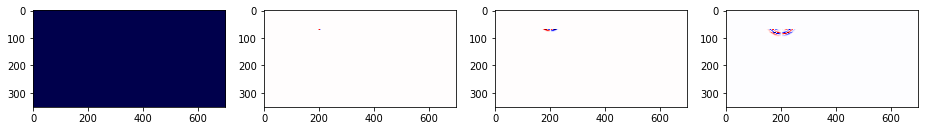

In [47]:
#NBVAL_IGNORE_OUTPUT
fobj = open("snaps3.bin", "rb")
# print(usave.data.shape)
snaps = np.fromfile(fobj, dtype=np.float32)
snaps = np.reshape(snaps, (-1, Nx, Nz))
# print(snaps.shape)
fobj.close()

plt.rcParams['figure.figsize'] = (20, 20)  # Increases figure size
    
imcnt = 1 # Image counter for plotting
plot_num = 4 # Number of images to plot

for i in [0, int(50 / 3), int(200 / 3), int(300 / 3)]:
   plt.subplot(1,plot_num+1, imcnt+1);
   imcnt = imcnt + 1
#    plot_image(snaps[i], cmap="seismic")
   plt.imshow(np.transpose(snaps[i,:,:]), cmap="seismic")

# print(snaps)
plt.show() 

In [63]:
#Forward Operator Setup
op = Operator(stencil + src_xx + src_zz)

# Reset the fields
vx.data[:] = 0.
vz.data[:] = 0.
sxx.data[:] = 0.
szz.data[:] = 0.
sxz.data[:] = 0.
rxx.data[:] = 0.
rzz.data[:] = 0.
rxz.data[:] = 0.

In [64]:
#Run Forward Operator
op()

Operator `Kernel` run in 3.97 s


## Plotting the entire 2D wavefield simulation
The code block below plots the entire wavefield that has been simulated for 300ms by the source.

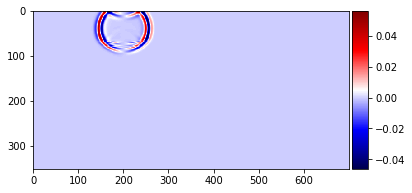

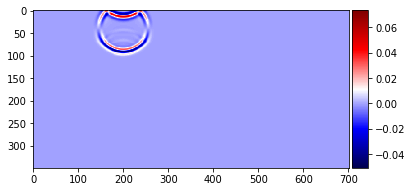

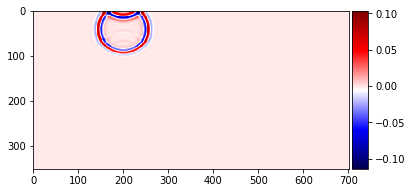

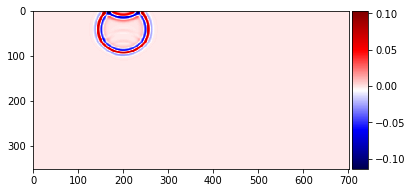

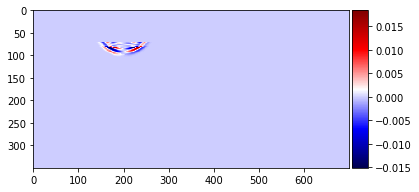

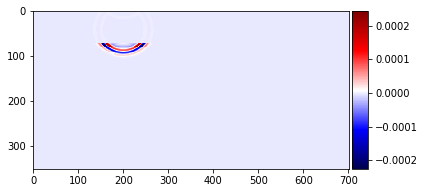

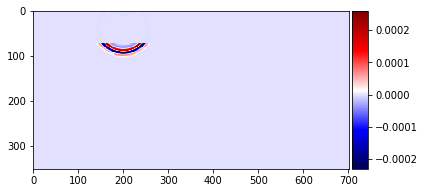

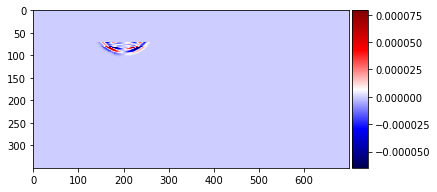

In [65]:
#Plots

plot_image(vx.data[0], cmap="seismic")
plot_image(vz.data[0], cmap="seismic")
plot_image(sxx.data[0], cmap="seismic")
plot_image(szz.data[0], cmap="seismic")
plot_image(sxz.data[0], cmap="seismic")
plot_image(rxx.data[0], cmap="seismic")
plot_image(rzz.data[0], cmap="seismic")
plot_image(rxz.data[0], cmap="seismic")
